In [1]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
import os
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("dark") # Theme for plots as Dark
sns.set_palette("viridis")
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, StratifiedKFold, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, mean_squared_log_error, r2_score
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor, HistGradientBoostingRegressor, IsolationForest
import optuna
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from catboost import Pool, CatBoostRegressor, cv
import sys
from tqdm import tqdm

import gc
gc.enable()

<div style="background-color: #8b888711; padding: 16px; border-radius: 12px; border: 2px solid white;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: white; font-weight: bold; font-size: 42px;">Dataset Overview</h1>

</div>

In [2]:
train_data = pd.read_csv("/kaggle/input/playground-series-s4e5/train.csv",index_col="id")
test_data = pd.read_csv("/kaggle/input/playground-series-s4e5/test.csv",index_col="id")
orig_data = pd.read_csv("/kaggle/input/flood-prediction-factors/flood.csv")

train_data = pd.concat([train_data,orig_data])

train_data.reset_index(inplace=True,drop=True)

In [3]:
train_data.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,5,8,5,8,6,4,4,3,3,4,...,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,...,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,...,7,3,7,5,6,8,2,3,3,0.530
3,3,4,6,5,4,8,4,7,6,8,...,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


In [4]:
test_data.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
id,,,,,,,,,,,,,,,,,,,,
1117957,4,6,3,5,6,7,8,7,8,4,8,5,7,5,6,3,6,4,4,5
1117958,4,4,2,9,5,5,4,7,5,4,2,4,7,4,5,1,7,4,4,3
1117959,1,3,6,5,7,2,4,6,4,2,7,9,2,5,5,2,3,6,8,3
1117960,2,4,4,6,4,5,4,3,4,4,7,8,4,6,7,6,4,2,4,4
1117961,6,3,2,4,6,4,5,5,3,7,4,3,2,6,4,6,8,4,5,5


<div style="background-color: #8b888711; padding: 16px; border-radius: 12px; border: 2px solid white;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: white; font-weight: bold; font-size: 42px;">Exploratory Data Analysis</h1>

</div>

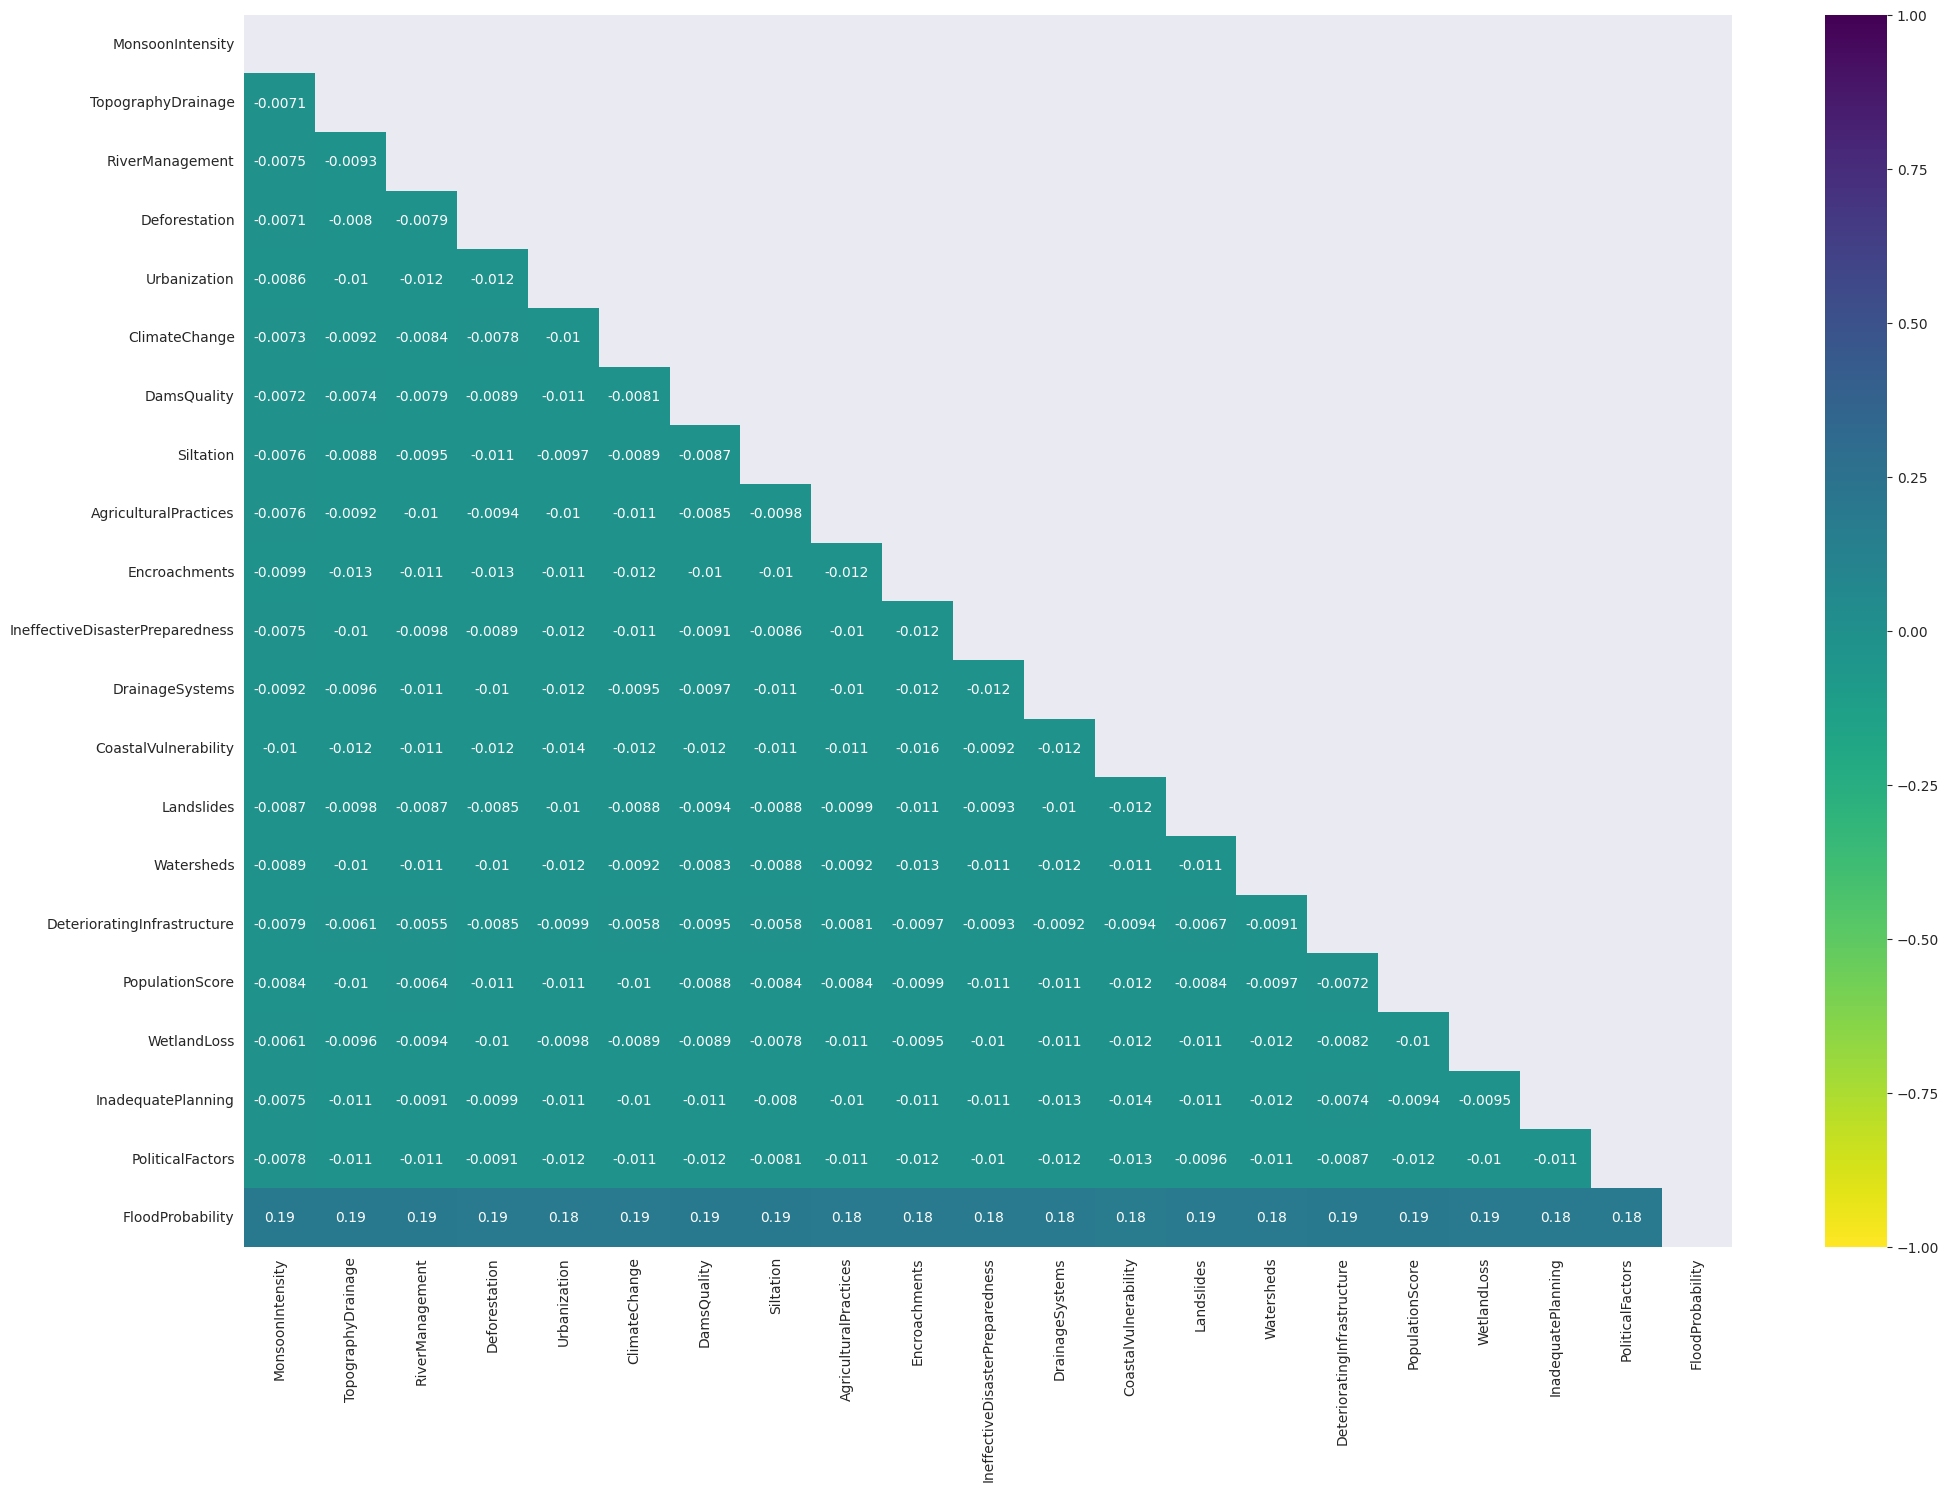

In [5]:
mask = np.triu(np.ones_like(train_data.corr()))
plt.figure(figsize=(24,16))
sns.heatmap(train_data.corr(), cmap="viridis_r", annot=True, mask=mask,vmin=-1,vmax=1);

# training

In [6]:
train_data.columns

Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'FloodProbability'],
      dtype='object')

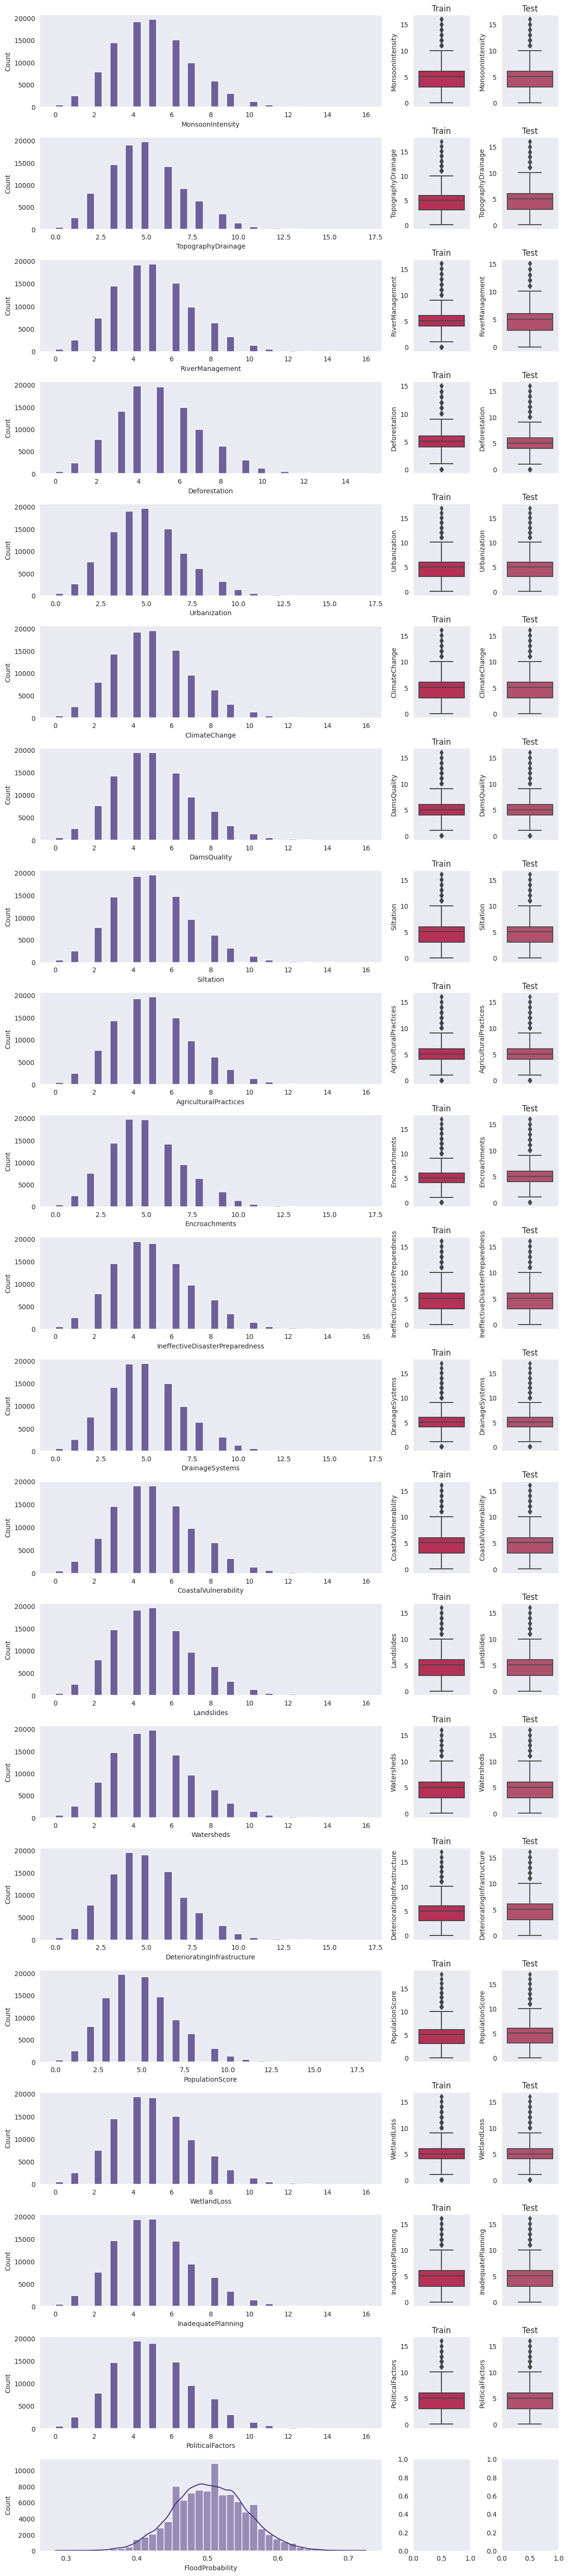

In [7]:
plt.subplots(21,3,figsize=(12,54),width_ratios=(3,0.5,0.5));

for ind,col in enumerate(train_data.columns):
    if col == "FloodProbability":
        plt.subplot(21,3,3*ind+1)
        sns.histplot(train_data[col][:100000],kde=True,bins=40);
        break
    plt.subplot(21,3,3*ind+1)
    sns.histplot(train_data[col][:100000],kde=False,bins=40);
    plt.subplot(21,3,3*ind+2)
    sns.boxplot(y = train_data[col][:100000],palette="rocket");
    plt.title("Train")
    plt.subplot(21,3,3*ind+3)
    sns.boxplot(y = test_data[col][:100000],palette="flare");
    plt.title("Test")
        
plt.tight_layout()

<div style="background-color: #8b888711; padding: 16px; border-radius: 12px; border: 2px solid white;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: white; font-weight: bold; font-size: 42px;">Training Models</h1>

</div>

In [8]:
seed = np.random.seed(6)

X = train_data.drop(["FloodProbability"],axis=1)
y = train_data["FloodProbability"]

<h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #BBBBBB; font-weight: bold; font-size: 36px;">Baseline Models</h1>
<hr style="color: #BBBBBB;">

In [9]:
lgbmmodel = LGBMRegressor(random_state=seed, verbose=-1)
print("CV R2 score of LGBM is ",cross_val_score(lgbmmodel,X,y,cv=4, scoring = 'r2').mean())

xgbmodel = XGBRegressor(random_state=seed)
print("CV R2 score of XGB is ",cross_val_score(xgbmodel,X,y,cv=4, scoring = 'r2').mean())

catmodel = CatBoostRegressor(random_state=seed, verbose=0)
print("CV R2 score of CAT is ",cross_val_score(catmodel,X,y,cv=4, scoring = 'r2').mean())

CV R2 score of LGBM is  0.7718520391015145


KeyboardInterrupt: 

<h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: #BBBBBB; font-weight: bold; font-size: 36px;">kFold CatBoost</h1>
<hr style="color: #BBBBBB;">

In [10]:
cat_params = {
    "iterations": 10000,
    "verbose": 1000,
    "task_type": "GPU",
    "random_state": seed,
    "early_stopping_rounds": 1000
}

submission = pd.DataFrame()
submission["id"] = test_data.index
submission["FloodProbability"] = 0

In [11]:
SPLITS = 5
REPEATS = 1
cat_score = []

for i,(tr,val) in enumerate(RepeatedKFold(n_splits=SPLITS, n_repeats=REPEATS,random_state=seed).split(X,y)):
    
    print("-"*30,f"FOLD {i+1}/{SPLITS*REPEATS}","-"*30)
    X_train, X_test, y_train, y_test = X.iloc[tr,:],X.iloc[val,:],y.iloc[tr],y.iloc[val]
    
    print("\n->","CAT:")
    train_dataset = Pool(data=X.iloc[tr,:],label=y.iloc[tr])
    eval_dataset = Pool(data=X.iloc[val,:],label=y.iloc[val])
    
    catmodel = CatBoostRegressor(**cat_params)
    catmodel.fit(train_dataset, use_best_model=True, eval_set=eval_dataset)
    r2 = r2_score(y.iloc[val], catmodel.predict(X.iloc[val,:]))
    cat_score.append(r2)
    print(f"Fold {i+1} R2 of CAT =", r2,"\n")
    submission["FloodProbability"] += catmodel.predict(test_data)
    
print("\n\n","-"*50,sep="")
print("CV score of CAT is ",np.array(cat_score).mean())

------------------------------ FOLD 1/5 ------------------------------

-> CAT:
Learning rate set to 0.07187
0:	learn: 0.0504799	test: 0.0503672	best: 0.0503672 (0)	total: 10.8s	remaining: 23h 58m 1s
1000:	learn: 0.0196911	test: 0.0197510	best: 0.0197510 (1000)	total: 17.2s	remaining: 2m
2000:	learn: 0.0195572	test: 0.0197092	best: 0.0197092 (2000)	total: 23.6s	remaining: 1m 10s
3000:	learn: 0.0194382	test: 0.0196762	best: 0.0196762 (3000)	total: 30.1s	remaining: 50.1s
4000:	learn: 0.0193273	test: 0.0196494	best: 0.0196494 (4000)	total: 36.5s	remaining: 36.5s
5000:	learn: 0.0192262	test: 0.0196310	best: 0.0196310 (5000)	total: 42.7s	remaining: 25.6s
6000:	learn: 0.0191343	test: 0.0196188	best: 0.0196187 (5992)	total: 49.1s	remaining: 16.4s
7000:	learn: 0.0190488	test: 0.0196113	best: 0.0196113 (6987)	total: 55.4s	remaining: 7.9s
7999:	learn: 0.0189681	test: 0.0196053	best: 0.0196052 (7990)	total: 1m 1s	remaining: 0us
bestTest = 0.01960522335
bestIteration = 7990
Shrink model to first 7

<div style="background-color: #8b888711; padding: 16px; border-radius: 12px; border: 2px solid white;">
    <h1 style="font-family:  'Garamond', 'Lucida Sans', sans-serif; text-align: center; color: white; font-weight: bold; font-size: 42px;"> Creating submission</h1>

</div>

In [13]:
submission["FloodProbability"] = submission["FloodProbability"]/(SPLITS*REPEATS)
submission.to_csv("submission.csv",index=False,header=True)
submission.head()